# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [4]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

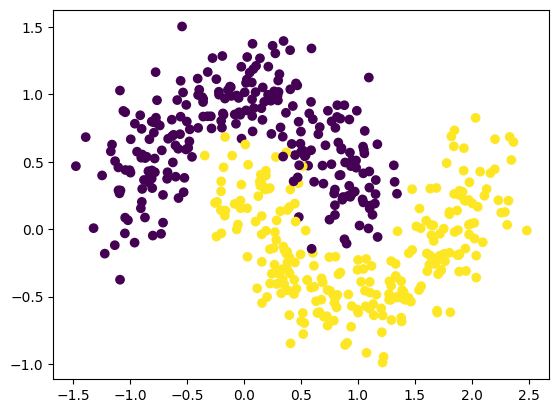

In [5]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(random_state=42, n_jobs=-1) # add some params
svm = SVC(kernel='linear', random_state=42, C=0.1) # here too

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

def plot_decisions(X, y, estimator, estimator_name, fig, grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    fig.add_subplot(grid)
    plt.title(f"{estimator_name}, accuracy = {accuracy_score(y_test, y_pred)}")
    plot_decision_regions(X, y, estimator)
    
def get_accuracy(X, y, estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

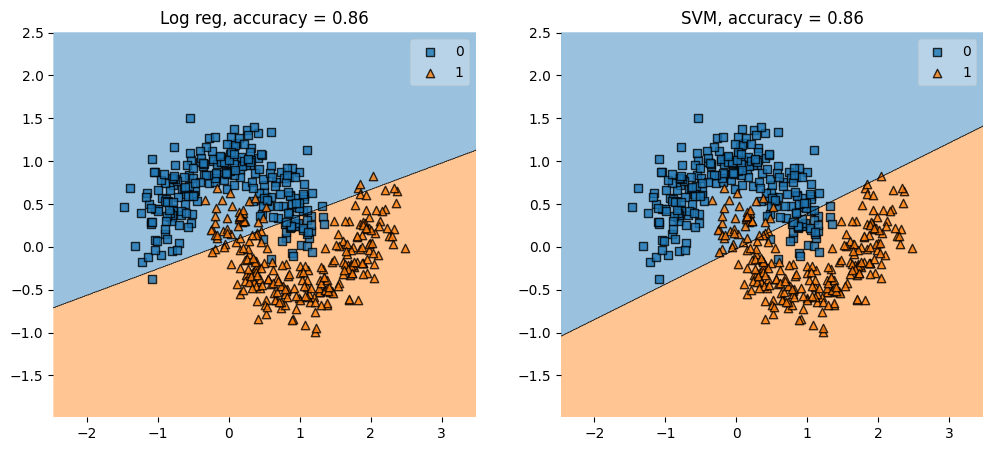

In [49]:
fig = plt.figure(figsize = (12, 5))
plot_decisions(moons_points, moons_labels, lr, 'Log reg', fig, 121)
plot_decisions(moons_points, moons_labels, svm, 'SVM', fig, 122)

The algorithms are not very good, 86% is quite good accuracy, but they did not catch the pattern in the data, they simply divided all the points into two parts with a straight line

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

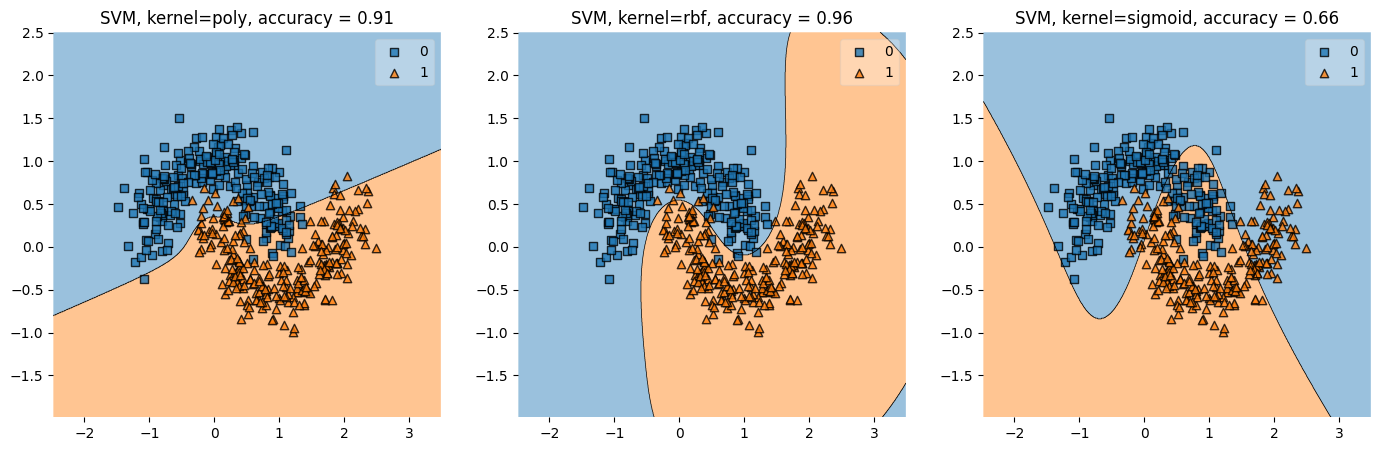

In [52]:
grid_kernel = ['poly', 'rbf', 'sigmoid']
fig = plt.figure(figsize = (17, 5))
for idx, ker in enumerate(grid_kernel):
    plot_decisions(moons_points, moons_labels, SVC(kernel=ker, random_state=42), f'SVM, kernel={ker}', fig, 131+idx)

The sigmoid is bad, it is clearly not suitable for this sample, but rbf has better results, it seems that by choosing the right parameters the algorithm can be further improved. The partition boundary depends on the function specified in kerenel, that is, it is either a polynomial, a sigmoid, or a Gaussian



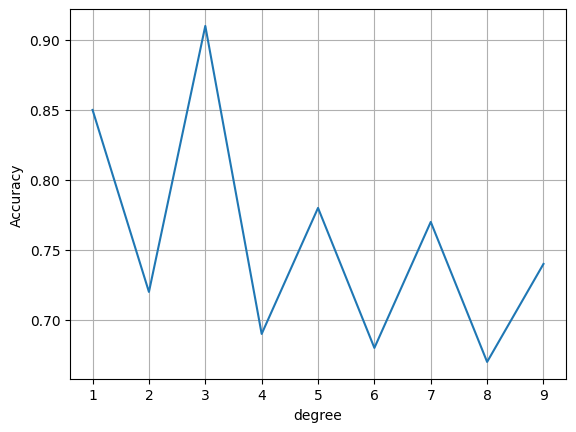

In [60]:
plt.plot(range(1, 10), [get_accuracy(moons_points, moons_labels, SVC(kernel='poly', degree=deg, random_state=42)) for deg in range(1, 10)])
plt.ylabel('Accuracy')
plt.xlabel('degree')
plt.grid()
plt.show()

We see that 3 is the best degree(and border similar to it) and odd degree better then even (on this data). Let's plot for degrees from 2 to 6

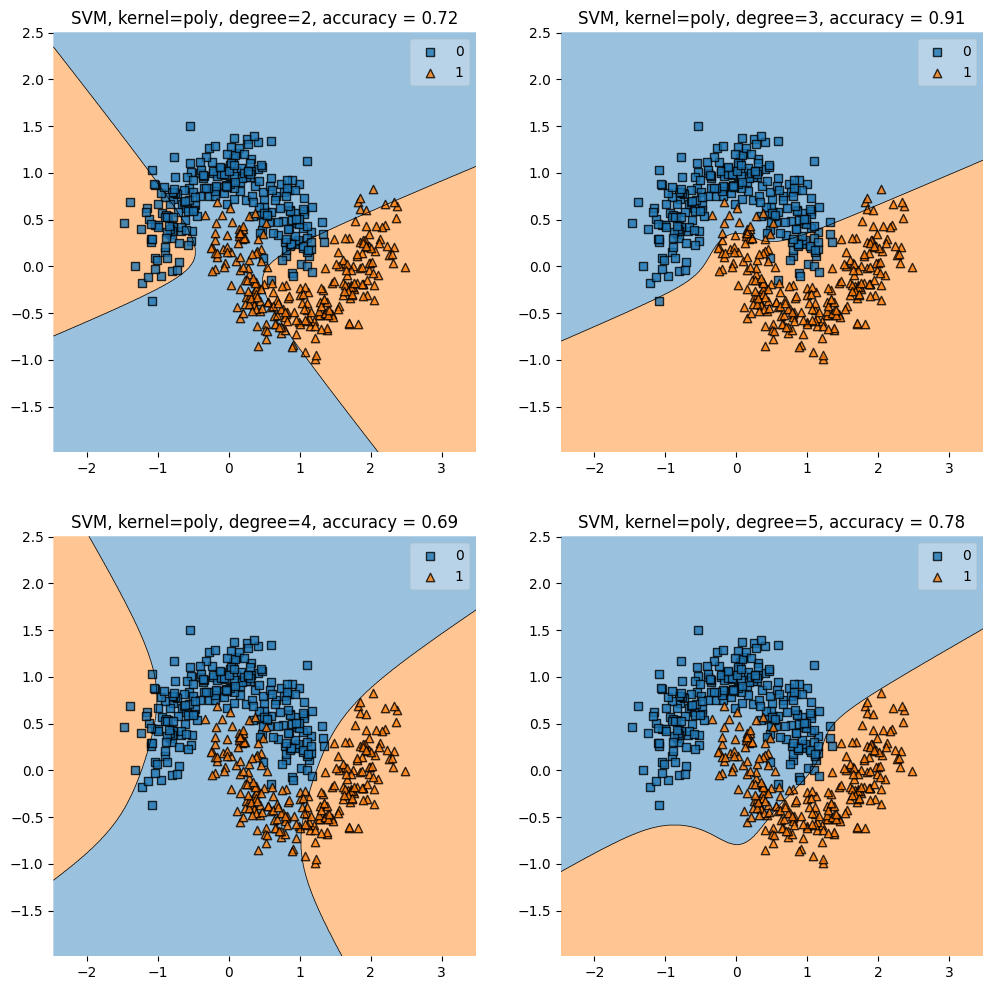

In [55]:
fig = plt.figure(figsize = (12, 12))
for idx, deg in enumerate(range(2, 6)):
    plot_decisions(moons_points, moons_labels, SVC(kernel='poly', random_state=42, degree=deg), f'SVM, kernel=poly, degree={deg}', fig, 221+idx)

Let's research for radial kernel

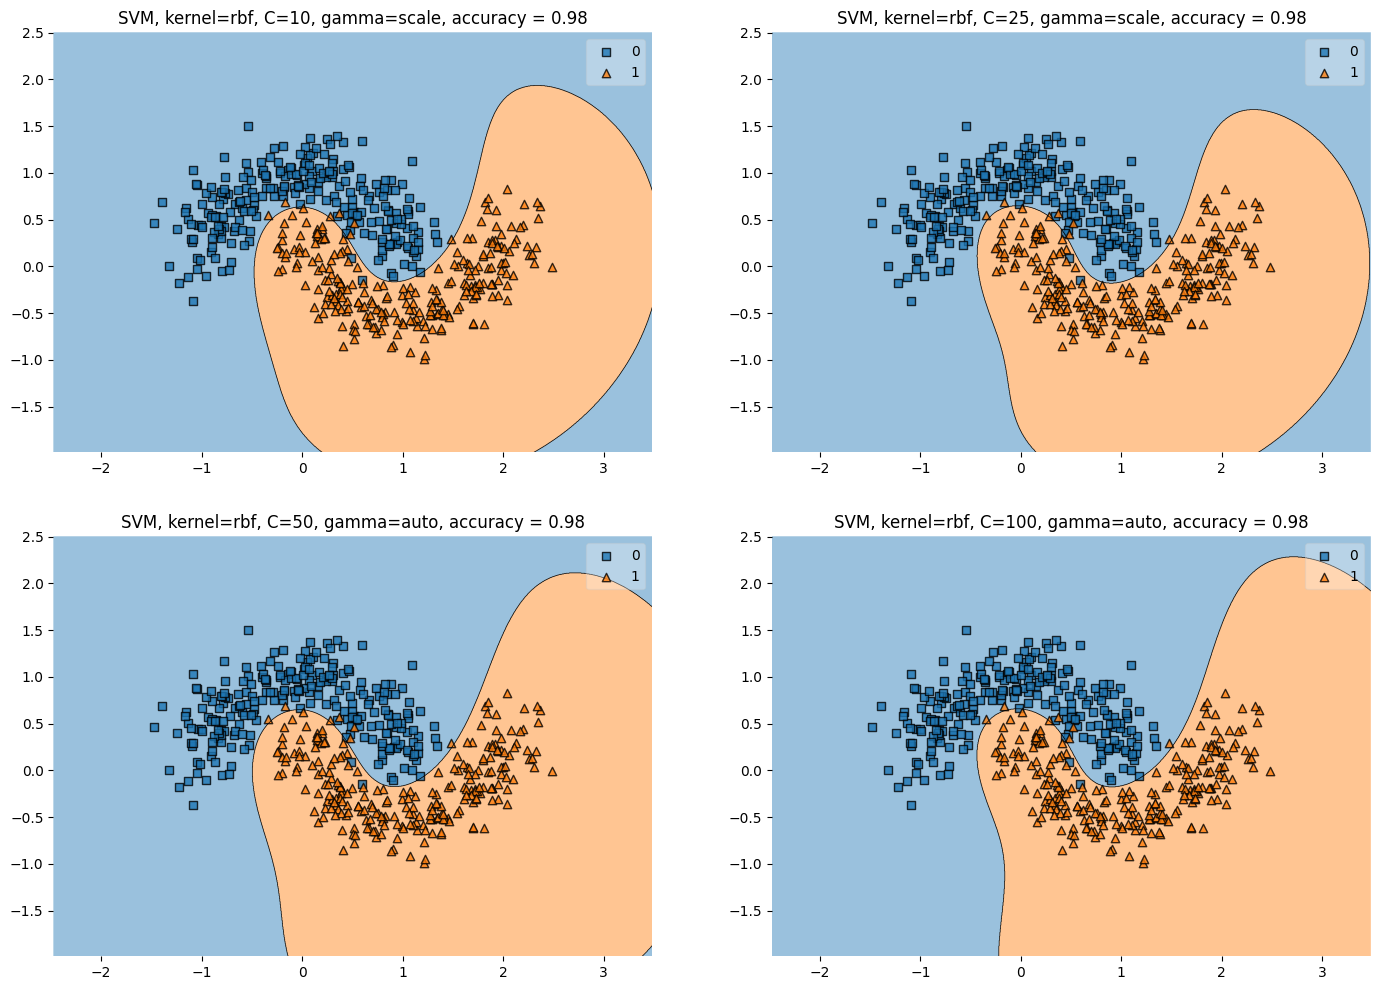

In [112]:
import itertools

C_grid = [0.1, 0.5, 1, 10, 25, 50, 100]
gamma_grid = ['auto', 'scale']

acc = []
grid = [e for e in itertools.product(C_grid, gamma_grid)]

for idx, params in enumerate(grid):
    acc.append(get_accuracy(moons_points, moons_labels, 
                   SVC(kernel='rbf', C=params[0], gamma=params[1], random_state=42)))

best_result = sorted(list(zip(grid, acc)), key=lambda d: d[1], reverse=True)
fig = plt.figure(figsize = (17, 12))

for idx, params in enumerate(best_result[:4]):
    plot_decisions(moons_points, moons_labels, SVC(kernel='rbf', C=params[0][0], gamma=params[0][1], random_state=42), 
                   f'SVM, kernel=rbf, C={params[0][0]}, gamma={params[0][1]}', fig, 221+idx)

It was possible to train the model to 98% accuracy (4 examples plot with different parameters), this is an excellent result, further improvement has little meaning, the model would rather be retrained, since some points are clearly in the depths of someone else's class

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

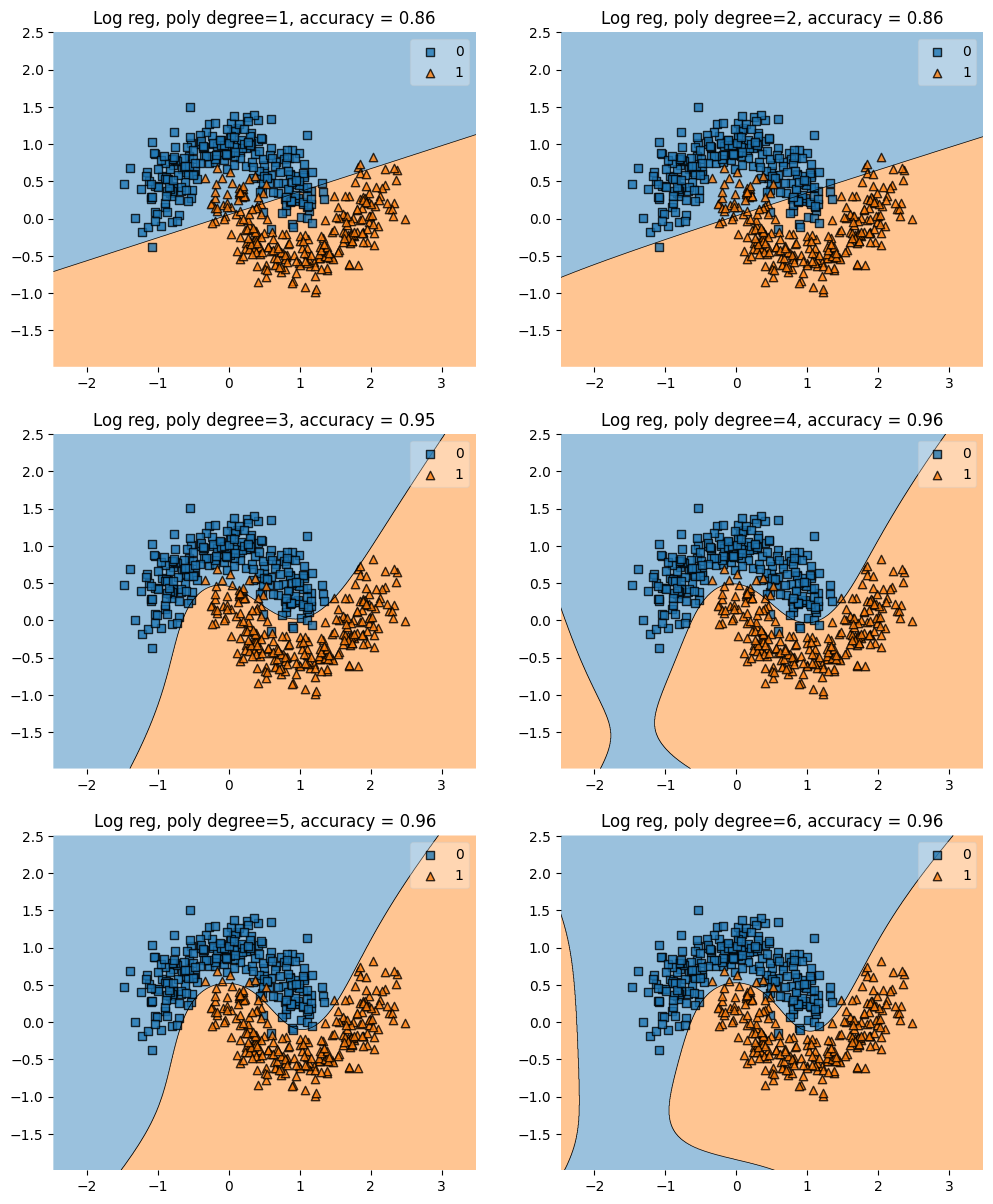

In [105]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig = plt.figure(figsize = (12, 20))
for deg in range(1, 7):
    plot_decisions(moons_points, moons_labels, 
                   Pipeline(steps=[('polyfeatures', PolynomialFeatures(deg)), 
                             ('logreg', LogisticRegression(random_state=42))]), f'Log reg, poly degree={deg}', fig, 420+deg)


The accuracy of logistic regression reaches 96 percent on the test sample (95% with degree 3) and no longer decreases, as expected, degree 3 or 4 is optimal, in this case, in the axes of the original features, the dividing surface will have the form of a polynomial of degree 3 (since further degrees apparently degenerate into it).

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

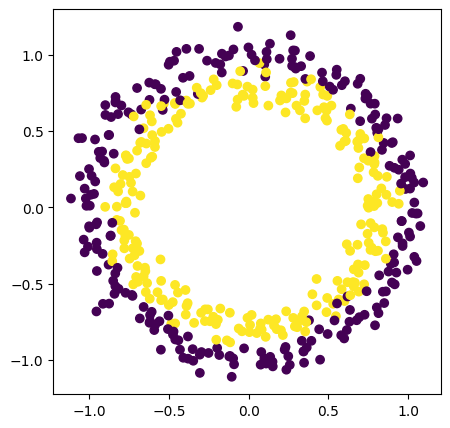

In [96]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

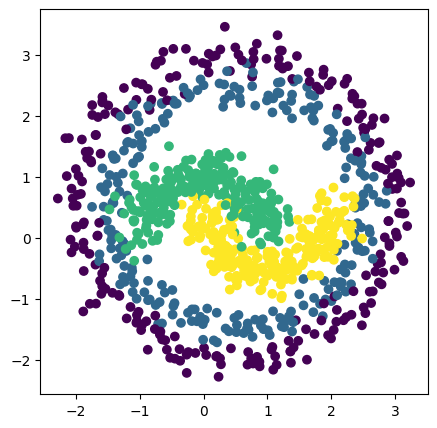

In [97]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

let's try linear regression with preprocessing

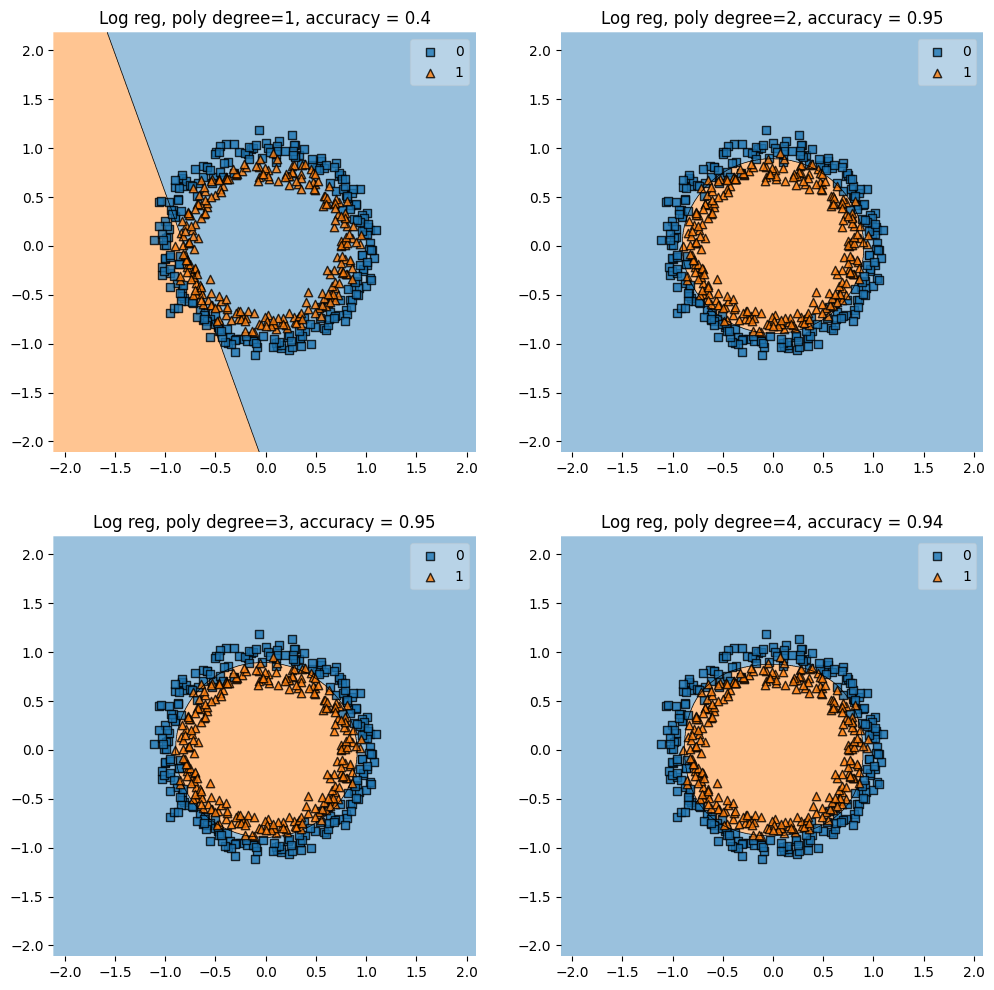

In [106]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

fig = plt.figure(figsize = (12, 12))

for deg in range(1, 5):
    plot_decisions(circles_points, circles_labels, 
                   Pipeline(steps=[('polyfeatures', PolynomialFeatures(deg)), 
                             ('logreg', LogisticRegression(random_state=42))]), f'Log reg, poly degree={deg}', fig, 220+deg)

As we see **degree = 2** get good quality

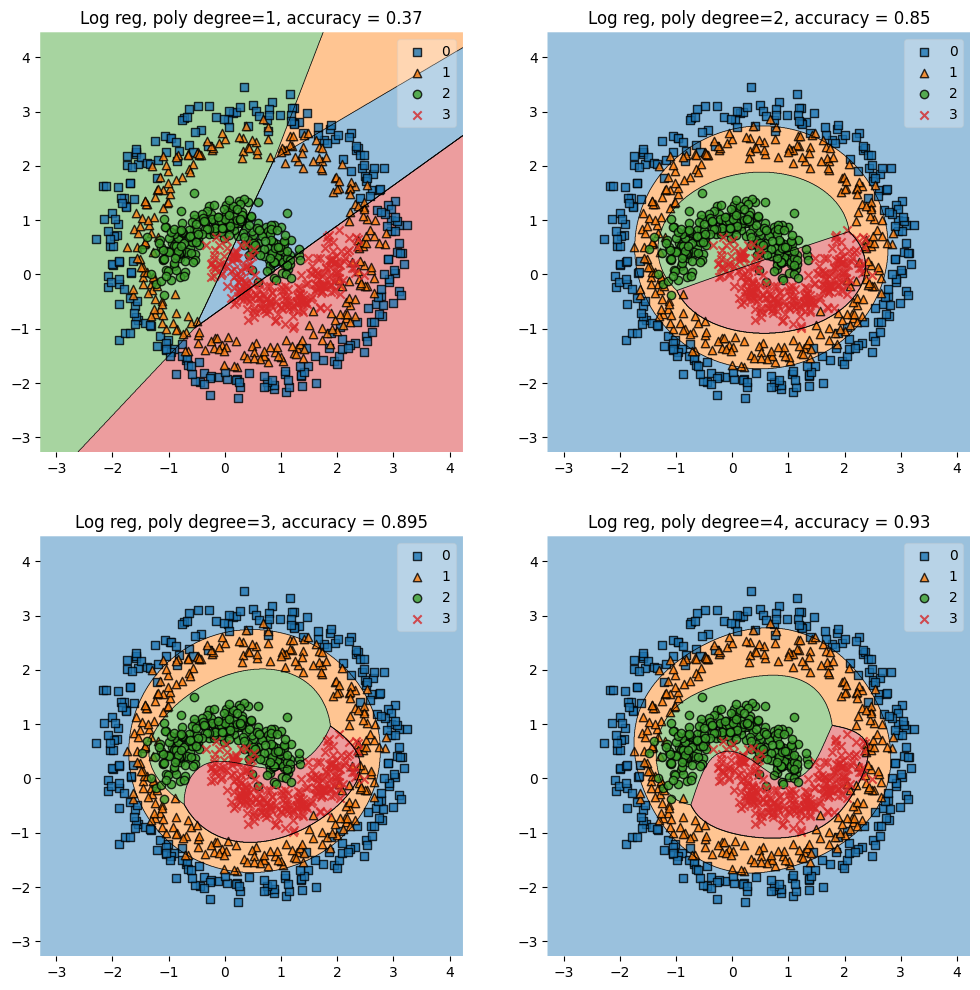

In [107]:
import warnings

warnings.filterwarnings("ignore")

fig = plt.figure(figsize = (12, 12))

for deg in range(1, 5):
    plot_decisions(points, labels, 
                   Pipeline(steps=[('polyfeatures', PolynomialFeatures(deg)), 
                             ('logreg', LogisticRegression(random_state=42))]), f'Log reg, poly degree={deg}', fig, 220+deg)

In this case we get 0.93 accuracy but library gets warnings on this case on convergence, but it is good too for this case

Let's try SVM

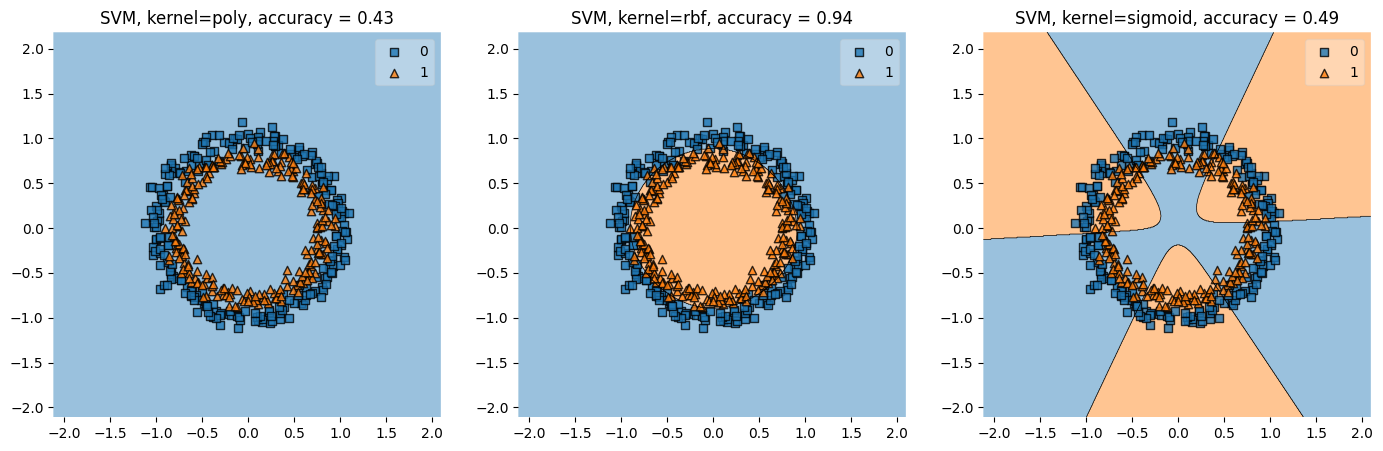

In [108]:
grid_kernel = ['poly', 'rbf', 'sigmoid']
fig = plt.figure(figsize = (17, 5))
for idx, ker in enumerate(grid_kernel):
    plot_decisions(circles_points, circles_labels, SVC(kernel=ker, random_state=42), f'SVM, kernel={ker}', fig, 131+idx)

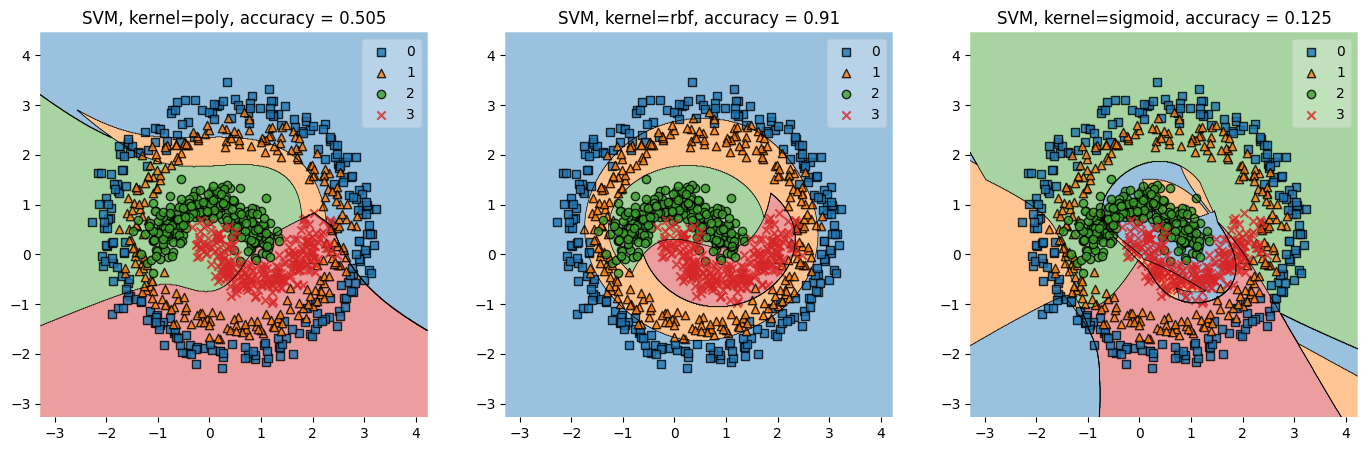

In [109]:
grid_kernel = ['poly', 'rbf', 'sigmoid']
fig = plt.figure(figsize = (17, 5))
for idx, ker in enumerate(grid_kernel):
    plot_decisions(points, labels, SVC(kernel=ker, random_state=42), f'SVM, kernel={ker}', fig, 131+idx)

As expected, **rbf** is best suited for these cases

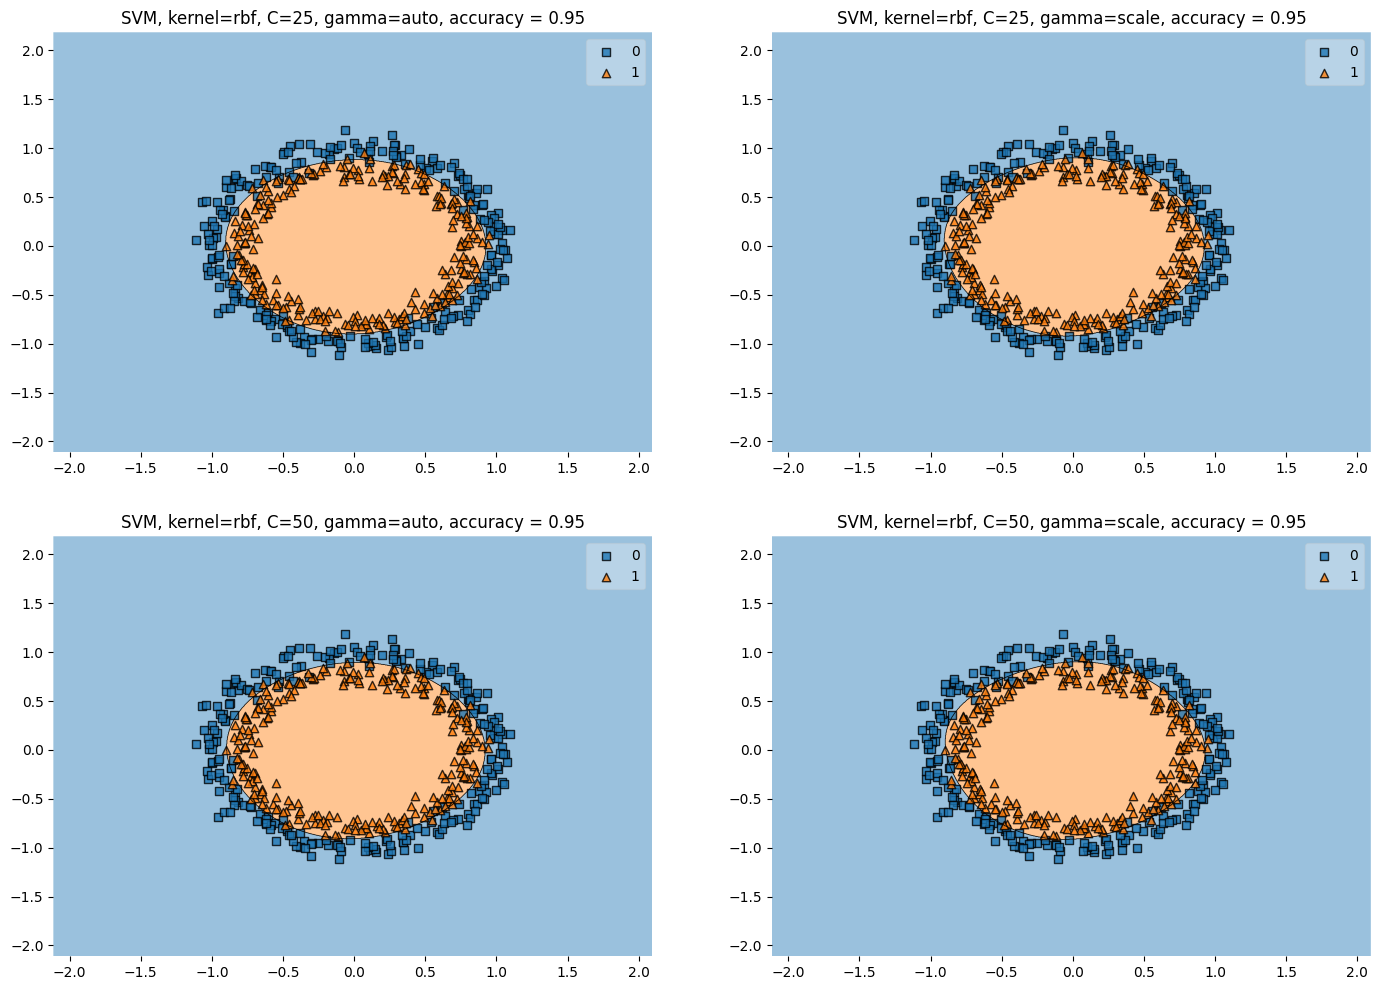

In [114]:
import itertools

C_grid = [0.1, 0.5, 1, 10, 25, 50, 100]
gamma_grid = ['auto', 'scale']

acc = []
grid = [e for e in itertools.product(C_grid, gamma_grid)]

for idx, params in enumerate(grid):
    acc.append(get_accuracy(circles_points, circles_labels, 
                   SVC(kernel='rbf', C=params[0], gamma=params[1], random_state=42)))

best_result = sorted(list(zip(grid, acc)), key=lambda d: d[1], reverse=True)
fig = plt.figure(figsize = (17, 12))

for idx, params in enumerate(best_result[:4]):
    plot_decisions(circles_points, circles_labels, SVC(kernel='rbf', C=params[0][0], gamma=params[0][1], random_state=42), 
                   f'SVM, kernel=rbf, C={params[0][0]}, gamma={params[0][1]}', fig, 221+idx)

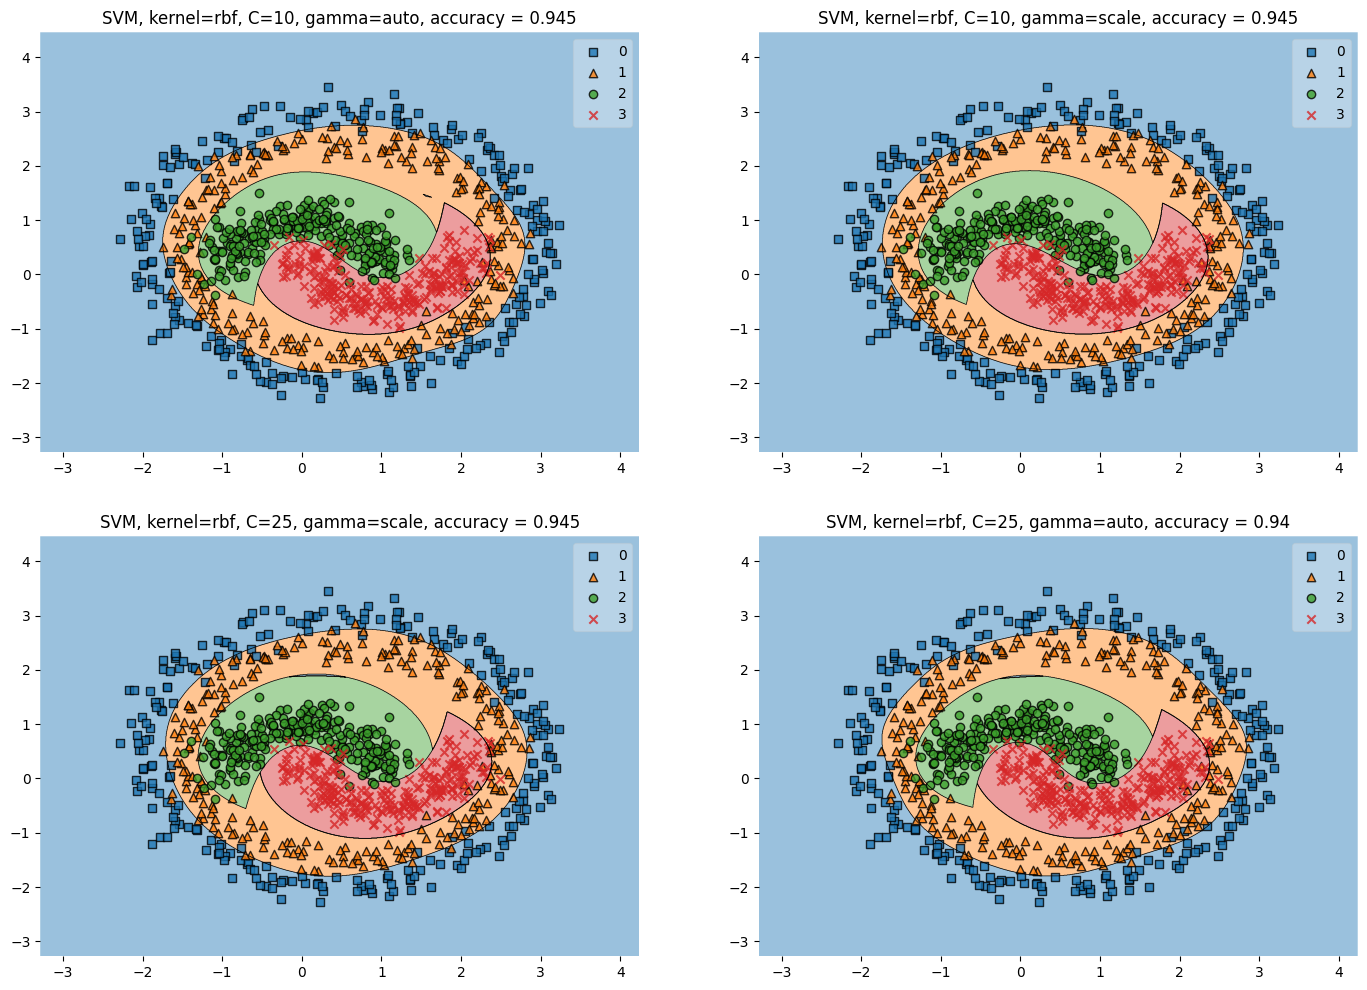

In [113]:
import itertools

C_grid = [0.1, 0.5, 1, 10, 25, 50, 100]
gamma_grid = ['auto', 'scale']

acc = []
grid = [e for e in itertools.product(C_grid, gamma_grid)]

for idx, params in enumerate(grid):
    acc.append(get_accuracy(points, labels, 
                   SVC(kernel='rbf', C=params[0], gamma=params[1], random_state=42)))

best_result = sorted(list(zip(grid, acc)), key=lambda d: d[1], reverse=True)
fig = plt.figure(figsize = (17, 12))

for idx, params in enumerate(best_result[:4]):
    plot_decisions(points, labels, SVC(kernel='rbf', C=params[0][0], gamma=params[0][1], random_state=42), 
                   f'SVM, kernel=rbf, C={params[0][0]}, gamma={params[0][1]}', fig, 221+idx)

We achieved 0.95/0.945 accuracy on this data and it is good I think

But we can degree change with poly kernel

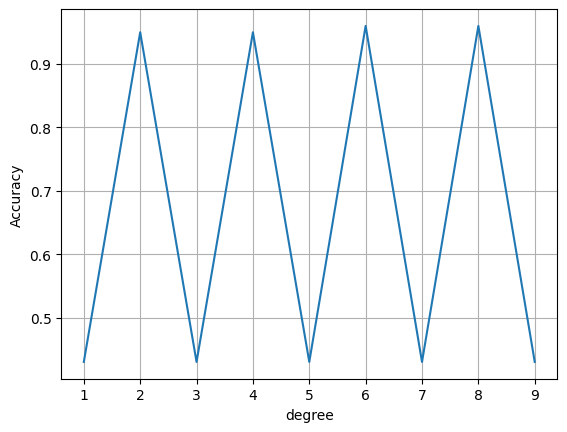

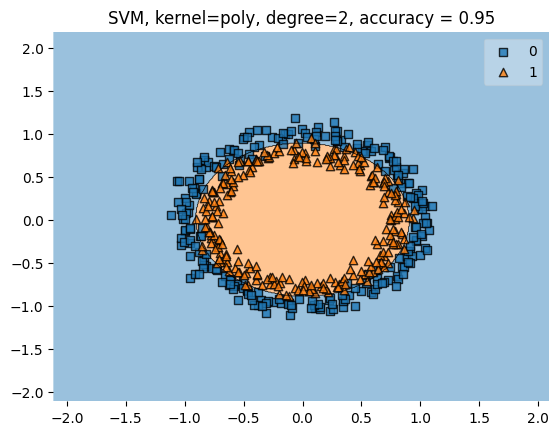

In [120]:
plt.plot(range(1, 10), [get_accuracy(circles_points, circles_labels, SVC(kernel='poly', degree=deg, random_state=42)) for deg in range(1, 10)])
plt.ylabel('Accuracy')
plt.xlabel('degree')
plt.grid()
plt.show()

plot_decisions(circles_points, circles_labels, SVC(kernel='poly', degree=2, random_state=42), 
                   f'SVM, kernel=poly, degree=2', plt.figure(), 111)

We can see good accuracy for even degree because of circle symmetric of border and very bad on odd

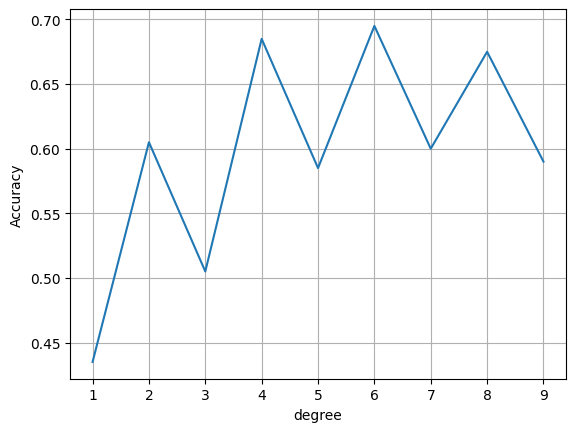

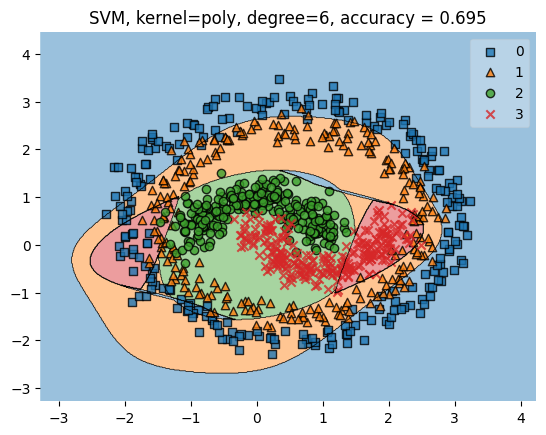

In [122]:
plt.plot(range(1, 10), [get_accuracy(points, labels, SVC(kernel='poly', degree=deg, random_state=42)) for deg in range(1, 10)])
plt.ylabel('Accuracy')
plt.xlabel('degree')
plt.grid()
plt.show()

plot_decisions(points, labels, SVC(kernel='poly', degree=6, random_state=42), 
                   f'SVM, kernel=poly, degree=6', plt.figure(), 111)

for combined data we have only 0.695 accuracy(( and it is worse that radial kernel